<a href="https://colab.research.google.com/github/perezrmaria/intonation_analysis/blob/main/trimmingpeaks_short_note_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install pretty_midi

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pretty_midi
import librosa
import statistics
from tqdm import tqdm
import os
from itertools import islice


from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/Shareddrives/Master Thesis')
import midi_functions
import peak_functions
import freqvibrato_functions
import dict_functions
import trim_functions

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
main_folder = '/content/drive/Shareddrives/Master Thesis/iter1_midi/wohlfahrt_first_30_no_accidentals'
all_info_method, all_time_method, len_every_mid = midi_functions.create_dic_all_method_original(main_folder, low_duration=0, high_duration=0.24)

### only trimming the first part of the signal

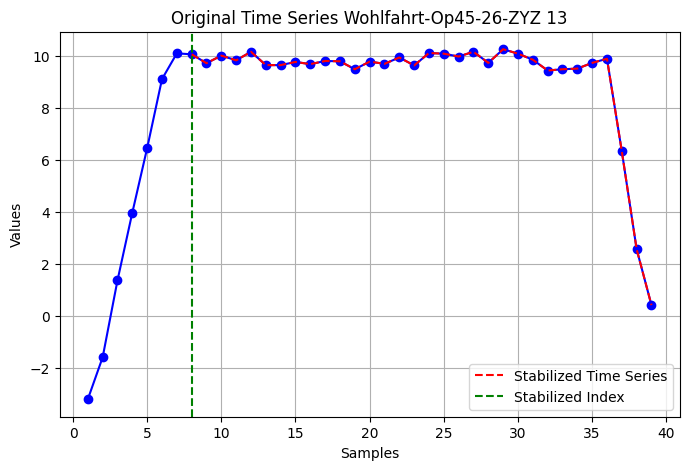

In [4]:
values = np.array(all_info_method['Wohlfahrt-Op45-26-ZYZ'][5])
time = np.arange(1, len(values)+1)

# sliding window approach to calculate slopes
window_size = 1
threshold_slope = 0.3

stabilized_index = None

for i in range(len(values) - window_size):
    window_slope = peak_functions.calculate_slope(time[i], values[i], time[i + window_size], values[i + window_size])
    if abs(window_slope) < threshold_slope or window_slope < -threshold_slope:
        stabilized_index = i + window_size
        break

plt.figure(figsize=(8, 5))
plt.plot(time, values, 'bo-')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.title('Original Time Series Wohlfahrt-Op45-26-ZYZ 13')

# if found, plot the stabilized time series
if stabilized_index is not None:
    plt.plot(time[stabilized_index:], values[stabilized_index:], 'r--', label='Stabilized Time Series')
    plt.axvline(time[stabilized_index], color='g', linestyle='--', label='Stabilized Index')
    plt.legend()

plt.grid(True)
plt.show()


### triming start and end of the signal-functions by slope

Random pitch bend example before making it a function

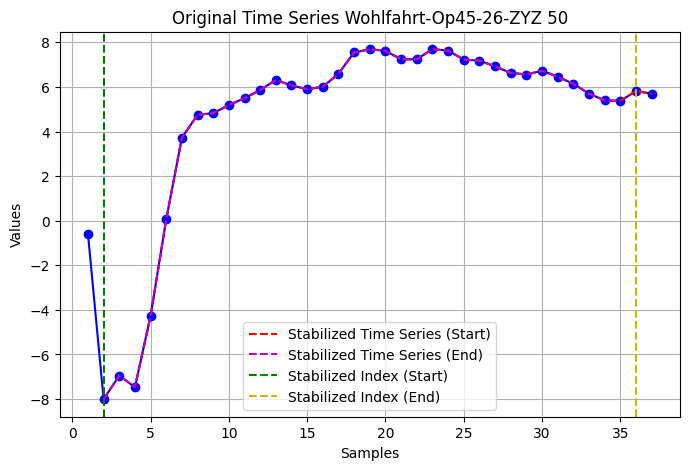

In [5]:
values = np.array(all_info_method['Wohlfahrt-Op45-26-ZYZ'][50])
time = np.arange(1, len(values) + 1)

window_size = 1
threshold_slope = 0.85
stabilized_index_start = None

for i in range(len(values) - window_size):
    window_slope = peak_functions.calculate_slope(time[i], values[i], time[i + window_size], values[i + window_size])

    if abs(window_slope) < threshold_slope or window_slope < -threshold_slope:
        stabilized_index_start = i + window_size
        break

# find the negative slope at the end of the signal
stabilized_index_end = None

for i in range(len(values) - window_size - 1, stabilized_index_start, -1):
    window_slope = peak_functions.calculate_slope(time[i - window_size], values[i - window_size], time[i], values[i])

    if window_slope > -threshold_slope:
        stabilized_index_end = i - window_size + 1  # includes the current sample where the negative slope starts
        break

# determine where the unexpected change occurs and trim the original signal accordingly
if stabilized_index_end is not None:
    values_trimmed = values[stabilized_index_start:stabilized_index_end]
    time_trimmed = time[stabilized_index_start:stabilized_index_end]
else:
    values_trimmed = values[stabilized_index_start:]
    time_trimmed = time[stabilized_index_start:]

plt.figure(figsize=(8, 5))
plt.plot(time, values, 'bo-')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.title('Original Time Series Wohlfahrt-Op45-26-ZYZ 50')

# plot the stabilized time series if found
if stabilized_index_start is not None:
    plt.plot(time[stabilized_index_start:], values[stabilized_index_start:], 'r--', label='Stabilized Time Series (Start)')
    if stabilized_index_end is not None:
        plt.plot(time[stabilized_index_start:stabilized_index_end], values[stabilized_index_start:stabilized_index_end], 'm--', label='Stabilized Time Series (End)')
    plt.axvline(time[stabilized_index_start], color='g', linestyle='--', label='Stabilized Index (Start)')
    if stabilized_index_end is not None:
        plt.axvline(time[stabilized_index_end], color='y', linestyle='--', label='Stabilized Index (End)')
    plt.legend()

plt.grid(True)
plt.show()

### Selecting the stabilized part only

<ipython-input-6-94c914c24624>:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(time[stabilized_index_start:stabilized_index_end], values[stabilized_index_start:stabilized_index_end], 'bo-', color='r')


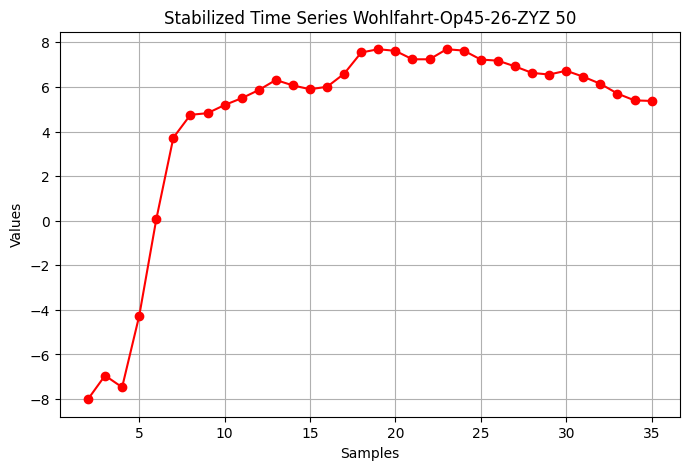

In [6]:
plt.figure(figsize=(8, 5))
plt.plot(time[stabilized_index_start:stabilized_index_end], values[stabilized_index_start:stabilized_index_end], 'bo-', color='r')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.title('Stabilized Time Series Wohlfahrt-Op45-26-ZYZ 50')
plt.grid(True)

prove that the function works

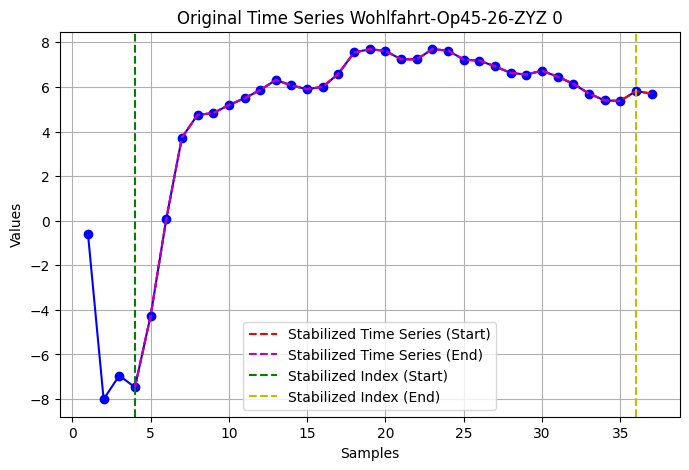

(array([-7.47070312, -4.27246094,  0.06103516,  3.72314453,  4.74853516,
         4.82177734,  5.18798828,  5.49316406,  5.859375  ,  6.31103516,
         6.06689453,  5.89599609,  6.00585938,  6.59179688,  7.54394531,
         7.69042969,  7.6171875 ,  7.23876953,  7.23876953,  7.69042969,
         7.62939453,  7.2265625 ,  7.17773438,  6.92138672,  6.62841797,
         6.55517578,  6.72607422,  6.45751953,  6.14013672,  5.70068359,
         5.39550781,  5.37109375]),
 array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
        21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]))

In [7]:
values = np.array(all_info_method['Wohlfahrt-Op45-26-ZYZ'][50])
peak_functions.trim_start_end_slope(values, np.arange(1, len(values) + 1), window_size, threshold_slope, plot_yes=True, index_number=0)

### Histogram for main pitch deviation for each short note

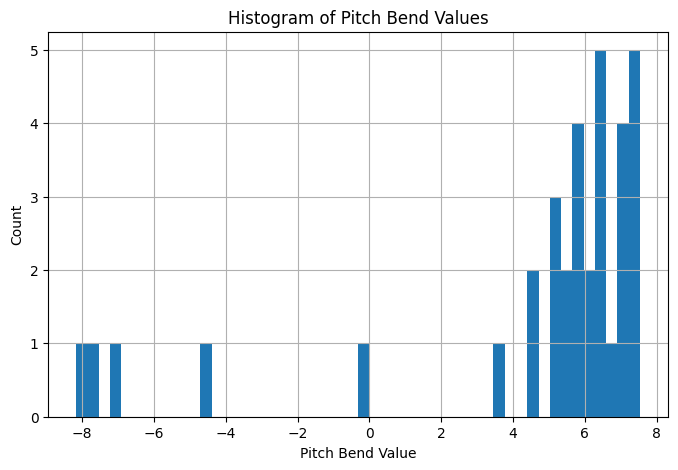

Value with highest count: 6.4345703125


In [8]:
num_bins = 50
hist, bins = np.histogram(values[stabilized_index_start:stabilized_index_end], bins=num_bins)

plt.figure(figsize=(8, 5))
plt.bar(bins[:-1], hist, width=np.diff(bins))
plt.xlabel('Pitch Bend Value')
plt.ylabel('Count')
plt.title('Histogram of Pitch Bend Values')
plt.grid(True)
plt.show()

bin_index_with_highest_count = np.argmax(hist)
value_with_highest_count = bins[bin_index_with_highest_count]
#print('Bin index with highest count:', bin_index_with_highest_count)
print('Value with highest count:', value_with_highest_count)

### For all items without plots

In [10]:
all_stabilized_values = {}
all_stabilized_time = {}
main_pitch_value = {}
for key, sub_dict in all_info_method.items():
    #print(f"Main key: {key}")
    for sub_key, value in sub_dict.items():
        #print(f"Sub key: {sub_key}, Value: {value}")
        if len(value)<=42:
            values = np.array(value)
            time = np.arange(1, len(values) + 1)
            stabilized_values, stabilized_time =peak_functions.trim_start_end_slope(values, time, window_size=5, threshold_slope=0.85, index_number=sub_key, plot_yes=False)
            #save stabilized_values, stabilized_time in a dictionary
            if key not in all_stabilized_values:
                all_stabilized_values[key] = {}
            if key not in all_stabilized_time:
                all_stabilized_time[key] = {}
            if key not in main_pitch_value:
                main_pitch_value[key] = {}

            all_stabilized_values[key][sub_key] = stabilized_values
            all_stabilized_time[key][sub_key] = stabilized_time
            num_bins = 50
            main_pitch_value[key][sub_key] = peak_functions.hist_pitch_max(num_bins, stabilized_values)
print('All items have been trimmed succesfully!')


All items have been trimmed succesfully!


### For all items with plots

[array(-7.20214844), array(-11.14501953), array(-11.48681641), array(-8.3984375), array(-1.953125), array(1.42822266), array(1.28173828), array(1.06201172), array(1.29394531)]


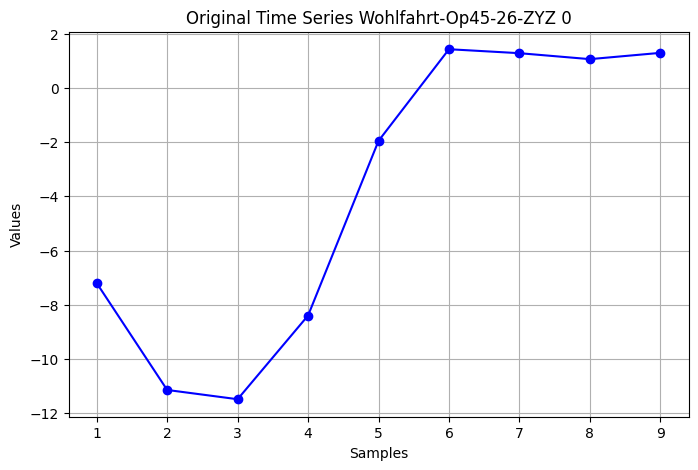

[array(2.06298828), array(9.91210938), array(10.00976562), array(10.20507812), array(10.15625), array(10.07080078), array(10.25390625), array(10.21728516), array(10.79101562), array(10.43701172), array(9.94873047), array(10.15625), array(10.21728516), array(10.64453125), array(10.7421875), array(10.18066406), array(10.13183594), array(9.74121094), array(10.07080078), array(10.08300781), array(9.53369141), array(9.22851562), array(9.04541016), array(9.19189453), array(9.33837891), array(9.08203125), array(8.64257812), array(7.8125), array(8.04443359), array(8.16650391), array(7.77587891), array(7.65380859)]


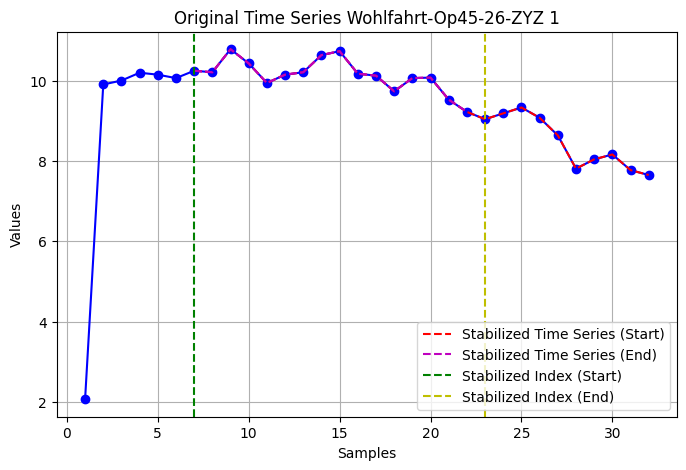

[array(8.23974609), array(-38.70849609), array(-31.29882812), array(-21.37451172), array(-12.21923828), array(-5.078125), array(-1.07421875), array(0.12207031), array(1.34277344), array(1.78222656), array(1.79443359), array(2.33154297), array(2.68554688), array(3.43017578), array(3.58886719), array(2.77099609), array(3.06396484), array(3.79638672), array(2.72216797), array(2.66113281), array(2.91748047), array(3.03955078), array(3.38134766), array(4.02832031), array(3.49121094), array(2.20947266), array(0.80566406), array(1.00097656), array(1.31835938), array(1.5625), array(1.26953125), array(1.15966797), array(1.51367188), array(1.22070312), array(1.14746094), array(2.07519531), array(2.89306641), array(1.86767578), array(0.48828125)]


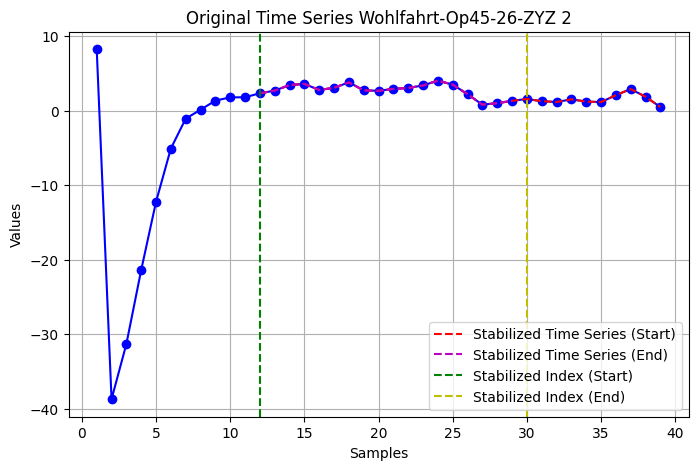

[array(8.67919922), array(-0.86669922), array(0.03662109), array(2.00195312), array(2.5390625), array(1.70898438), array(2.28271484), array(2.63671875), array(3.56445312), array(3.38134766), array(4.56542969), array(5.6640625), array(5.17578125), array(4.33349609), array(4.60205078), array(4.54101562), array(4.26025391), array(4.41894531), array(4.94384766), array(4.4921875), array(4.46777344), array(4.38232422), array(5.23681641), array(4.45556641), array(4.30908203), array(4.35791016), array(3.99169922), array(3.89404297), array(2.89306641), array(2.63671875), array(1.86767578), array(1.72119141), array(1.30615234), array(0.390625), array(0.03662109), array(-0.92773438), array(-1.08642578), array(-0.75683594), array(-1.53808594)]


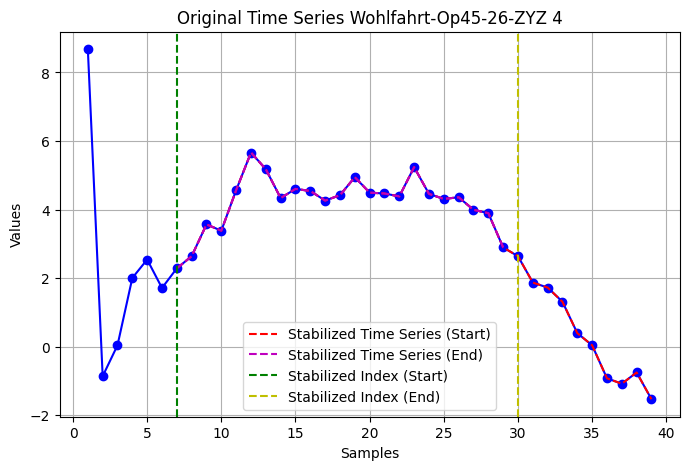

[array(-3.19824219), array(-1.58691406), array(1.3671875), array(3.96728516), array(6.4453125), array(9.09423828), array(10.08300781), array(10.04638672), array(9.70458984), array(9.99755859), array(9.81445312), array(10.14404297), array(9.63134766), array(9.63134766), array(9.75341797), array(9.66796875), array(9.79003906), array(9.77783203), array(9.47265625), array(9.765625), array(9.68017578), array(9.92431641), array(9.61914062), array(10.09521484), array(10.07080078), array(9.9609375), array(10.14404297), array(9.71679688), array(10.24169922), array(10.07080078), array(9.83886719), array(9.42382812), array(9.47265625), array(9.49707031), array(9.71679688), array(9.87548828), array(6.32324219), array(2.56347656), array(0.41503906)]


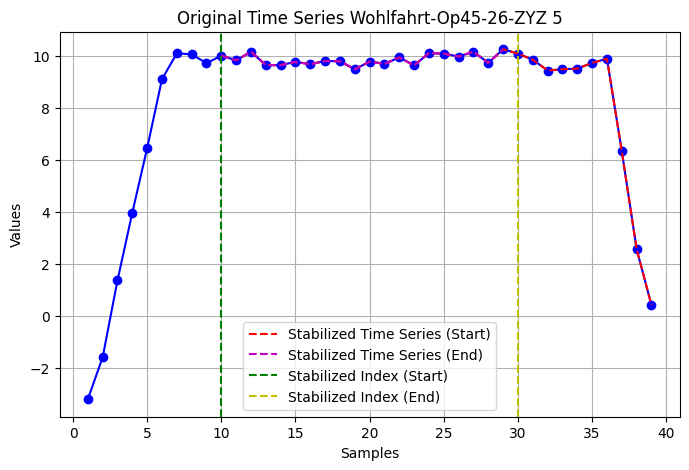

In [20]:
all_stabilized_values = {}
for key, item in islice(all_info_method['Wohlfahrt-Op45-26-ZYZ'].items(), 5):
    print(item)
    if len(item)<=42:
        values = np.array(item)
        time = np.arange(1, len(values) + 1)
        stabilized_values, stabilized_time = peak_functions.trim_start_end_slope(values, time, window_size=5, threshold_slope=0.85, index_number=key)
        #save stabilized_values, stabilized_time in a dictionary
        all_info_method['Wohlfahrt-Op45-26-ZYZ'][key] = stabilized_values

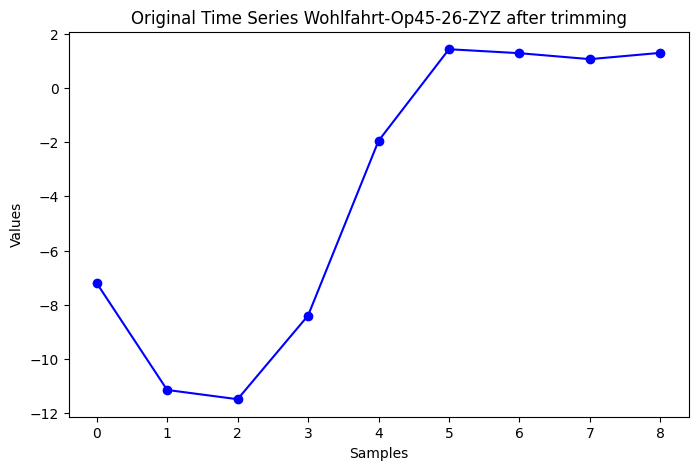

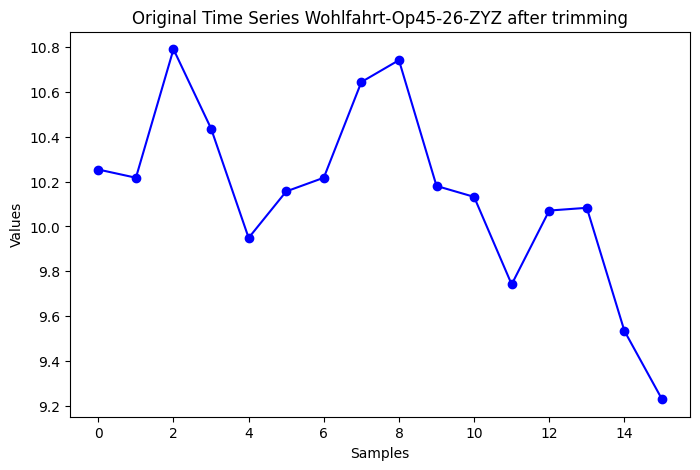

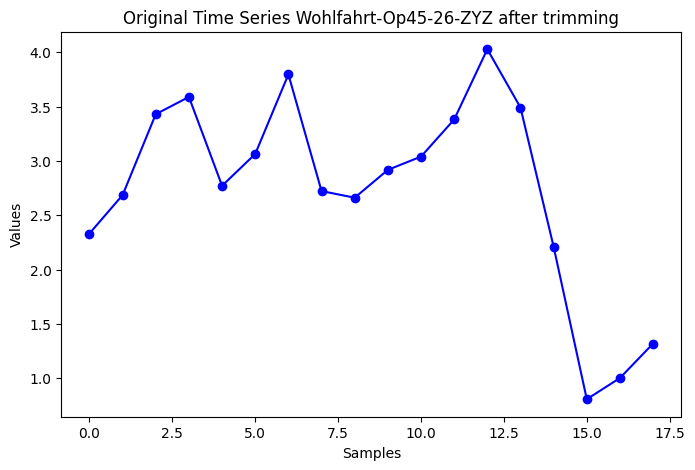

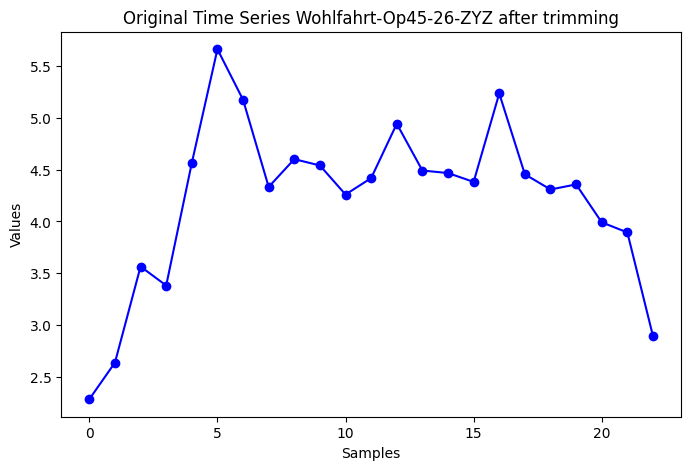

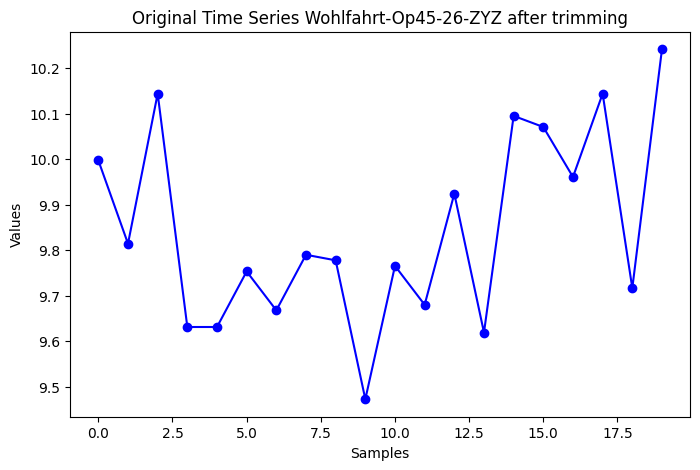

In [22]:
for key, item in islice(all_info_method['Wohlfahrt-Op45-26-ZYZ'].items(), 5):
  plt.figure(figsize=(8, 5))
  plt.plot(item, 'bo-')
  plt.xlabel('Samples')
  plt.ylabel('Values')
  plt.title(f'Original Time Series Wohlfahrt-Op45-26-ZYZ after trimming')
  plt.plot()